# 03 - Interfaces, Nodes, and Workflows

#### Questions

- What are Nipype interfaces, nodes and workflows?
- Why bother using them?

#### Objective

- Setting up interface nodes
- Connecting different interfaces with each other

## Install dependencies and download data

In this notebook we use tools of the [FSL Software Library](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki). Running the cell below on Colab will: 
- create a data directory and working directory
- install nilearn and nipype
- install fsl and [setup required environment variables](https://andysbrainbook.readthedocs.io/en/latest/unix/Unix_04_ShellsVariables.html)
- download the mni template

*Important: Once you lose connection to the Colab runtime, you will have to install FSL again (i.e., re-run the cell below). Note that Colab has an idle timeout of 90 minutes. That's one of the downsides of using Colab*

In [ ]:
import os

!mkdir /data
!mkdir -p /output/working_dir

!pip install nilearn
!pip install nipype

# install fsl
!sudo apt-get remove -y --purge man-db
!apt-get update
!apt-get install neurodebian-archive-keyring
!add-apt-repository "deb http://neuro.debian.net/debian bionic main contrib non-free"
!apt-get install fsl-core

fslpath="/usr/share/fsl/5.0" 
os.environ["FSLOUTPUTTYPE"] = "NIFTI"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")
!. ${FSLDIR}/etc/fslconf/fsl.sh
!export FSLDIR PATH

os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

# add mni template to fsl dir
!mkdir /usr/share/fsl/5.0/data/standard
!gdown --id 1lytUR8CJkcvGIdhndoLjKCUloKl80iCG 
!unzip /content/mniatlas.zip -d /usr/share/fsl/5.0/data/standard



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 5.3 MB/s 
     |████████████████████████████████| 500 kB 44.2 MB/s 
     |████████████████████████████████| 130 kB 63.1 MB/s 
     |████████████████████████████████| 421 kB 65.1 MB/s 
     |████████████████████████████████| 5.1 MB 35.0 MB/s 
     |████████████████████████████████| 41 kB 554 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  groff-base libnvidia-common-460 libpipeline1
Use 'sudo apt autoremove' to remove them.
The following packages will be REMOVED:
  man-db*
0 upgraded, 0 newly installed, 1 to remove and 20 not upgraded.
After this operation,

In this notebook, we will use [NYU Slow Flanker dataset](https://openneuro.org/datasets/ds000102/versions/00001) from Openneuro. In this study, healthy adults underwent MRI scanning while performing an event-related [Eriksen Flanker task](https://en.wikipedia.org/wiki/Eriksen_flanker_task).

Running the cell below will download the first three subjects of the dataset. The data will be stored in ```/data```.

In [ ]:
# download dataset
!gdown --id 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
!unzip /content/ds000102.zip -d /data

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
To: /content/ds000102.zip
100% 204M/204M [00:02<00:00, 71.5MB/s]
Archive:  /content/ds000102.zip
   creating: /data/ds000102/
  inflating: /data/ds000102/task-flanker_bold.json  
  inflating: /data/ds000102/.DS_Store  
  inflating: /data/ds000102/CHANGES  
   creating: /data/ds000102/sub-01/
  inflating: /data/ds000102/README   
  inflating: /data/ds000102/dataset_description.json  
  inflating: /data/ds000102/T1w.json  
  inflating: /data/ds000102/participants.tsv  
   creating: /data/ds000102/sub-02/
   creating: /data/ds000102/sub-03/
  inflating: /data/ds000102/sub-01/.DS_Store  
   creating: /data/ds000102/sub-01/anat/
   creating: /data/ds000102/sub-01/func/
   creating: /dat

## Define parameters

As always, we start with defining some parameters, such as the data and output directory. Also, we will create a variable pointing to anatomical image of the first subject.

In [ ]:
data_dir = "/data/ds000102"
output_dir = "/output"

test_subj = "sub-01"
test_anat = f"{data_dir}/{test_subj}/anat/{test_subj}_T1w.nii.gz"

## Nipype Interfaces

Last week we converted some DICOMS to NIfTI files using the Nipype interface of ```dcm2niix```. Now we will have a look at further interfaces and will learn how to connect them.

To recap: interfaces are wrappers that allow Nipype to run programs that are written in programming languages other than Python. For example, we can access the tools of the FSL software library within Python. Let's have a look at an example:

### Brain extraction using FSL's ```BET```

Besides the brain, raw MRI images contain non-brain tissue, i.e., skin, muscles, eye balls etc. These non-brain tissues may complicate some automated preprocessing steps such as [brain image segmentation](https://andysbrainbook.readthedocs.io/en/latest/SPM/SPM_Short_Course/SPM_04_Preprocessing/04_SPM_Segmentation.html). Thus, the so called [brain extraction](https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/Preprocessing/Skull_Stripping.html) or skullstripping is often included as a preliminary step in the preprocessing pipeline, improving speed and accuracy of image segmentation.

To perform skullstripping, FSL offers the [BET (Brain Extraction Tool)](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) which which we will access through its corresponding Nipype interface:

In [ ]:
from nipype.interfaces.fsl import BET

In [ ]:
BET.help()

Wraps the executable command ``bet``.

FSL BET wrapper for skull stripping

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                input file to skull strip
                argument: ``%s``, position: 0

        [Optional]
        out_file: (a pathlike object or string representing a file)
                name of output skull stripped image
                argument: ``%s``, position: 1
        outline: (a boolean)
                create surface outline image
                argument: ``-o``
        mask: (a boolean)
                c

Analogous to using the ```dcm2niix``` interface in last week's notebook, we will create an interface object. However, this time we will directly provide the parameters. 

(Note from the ```BET.help()``` output above that ```in_file``` is the only mandatory parameter, but here we also want to define the location of the output file (default is the current working directory) and tell nipype to create a [brain mask](http://andysbrainblog.blogspot.com/2012/11/a-note-of-fmri-masks.html) as well) 

In [ ]:
strip_skull = BET(in_file = test_anat,
                  out_file = f"{output_dir}/{test_subj}_T1w_bet.nii",
                  mask = True)

Now let's run the ```BET``` interface:

In [ ]:
result_bet = strip_skull.run()

After running ```BET```, we can have a look at the created output files by calling the ```outputs``` argument of the ``BET`` object:

In [ ]:
print(result_bet.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /output/sub-01_T1w_bet_mask.nii
meshfile = <undefined>
out_file = /output/sub-01_T1w_bet.nii
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>



We can use the paths from the ```outputs``` argument to easily access the respective files and plot them:

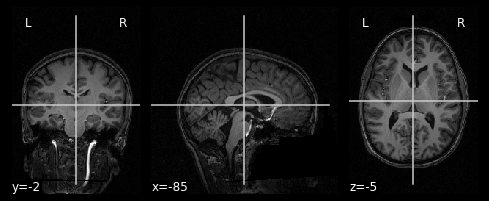

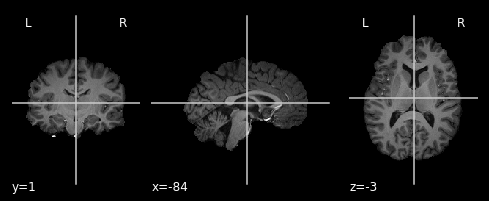

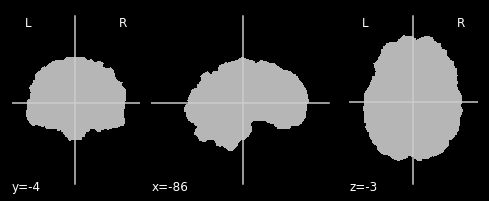

In [ ]:
from nilearn import plotting

plotting.plot_anat(test_anat, dim=-1)                                           # set dim=-1 to increase contrast
plotting.plot_anat(result_bet.outputs.out_file, dim=-1)
plotting.plot_anat(result_bet.outputs.mask_file)

## instead of using the outputs argument we can also directly provide the respective path:
# plotting.plot_anat("/output/sub-01_T1w_bet.nii")

Nilearn's plotting module also allows us to outline the brain mask on top of the non-skullstripped anatomical image. This is useful to determine how well the brain extraction worked.

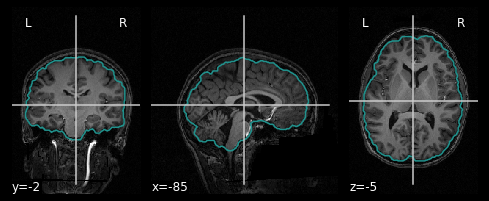

In [ ]:
disp_anat = plotting.plot_anat(test_anat, dim=-1)
disp_anat.add_contours(result_bet.outputs.mask_file, levels=[0.5])

### Brain segmentation using FSL's ```FAST```

Put simply, [segmentation](https://andysbrainbook.readthedocs.io/en/latest/SPM/SPM_Short_Course/SPM_04_Preprocessing/04_SPM_Segmentation.html) is all about learning which voxels belong to which tissue type (i.e., grey matter, white matter and cerebrosplinal fluid (CSF)). This information can aid further steps down the preprocessing pipeline such as normalizing the image to and standard space.

Various neuroimaging software suites provide functionalities to perform segmentation. Here, we will use FSL's [```FAST```](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) tool as we have FSL already installed.

In [ ]:
from nipype.interfaces.fsl import FAST

FAST.help()

Wraps the executable command ``fast``.

FSL FAST wrapper for segmentation and bias correction

For complete details, see the `FAST Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> fastr = fsl.FAST()
>>> fastr.inputs.in_files = 'structural.nii'
>>> fastr.inputs.out_basename = 'fast_'
>>> fastr.cmdline
'fast -o fast_ -S 1 structural.nii'
>>> out = fastr.run()  # doctest: +SKIP

Inputs::

        [Mandatory]
        in_files: (a list of items which are a pathlike object or string
                  representing an existing file)
                image, or multi-channel set of images, to be segmented
                argument: ``%s``, position: -1

        [Optional]
        out_basename: (a pathlike object or string representing a file)
                base name of output files
                argument: ``-o %s``
        number_classes: (1 <= an integer <= 10)
                number of tissue-type classes
            

Before setting up and running the inferface, however, we will have a look at some fundamental concepts of Nipype: Nodes and Workflows.

## Nipype Nodes and Workflows

As mentioned earlier, segmentation can be improved when we remove any non-brain tissue beforehand. Thus, we would use the output from the ```BET``` interface (i.e., the extracted brain image) as the input for the segmentation interface. Such process can be streamlined by using Nipype's Nodes and Worklows. These utilites make up the main benefits of Nipype. To quote from the [official Nipype tutorial](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html):

> A workflow controls the setup and the execution of individual interfaces. Let's assume you want to run multiple interfaces in a specific order, where some have to wait for others to finish while others can be executed in parallel. The nice thing about a nipype workflow is, that the workflow will take care of input and output of each interface and arrange the execution of each interface in the most efficient way.

>A workflow therefore consists of multiple Nodes, each representing a specific Interface and directed connection between those nodes. Those connections specify which output of which node should be used as an input for another node.

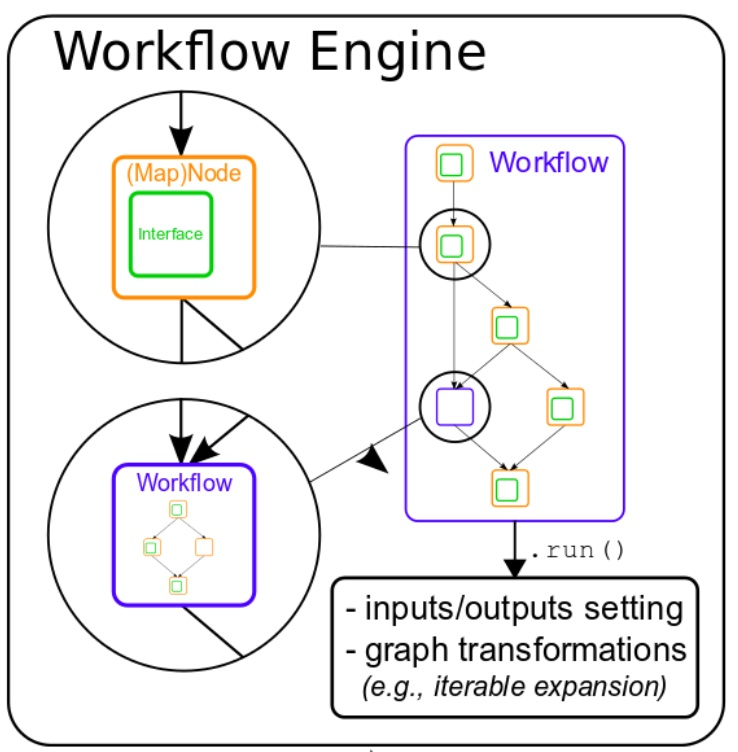

Alright, let's setup Nodes for the ```BET``` and ```FAST```interfaces. The general form of a node looks as follows:

```nodename = Nodetype(interface_function(), name='labelname')```

In [ ]:
from nipype import Node, Workflow

# Skullstrip Node
strip_skull = Node(BET(in_file=test_anat,
                           mask=True),
                   name = "strip_skull")

# Segmentation Node
segment     = Node(FAST(),
                   name = "segment")

We have now created the respective nodes (note that nothing has been executed yet). The next step is to initialize a Workflow object:

In [ ]:
# Initialize workflow
wf = Workflow(name = "test_workflow",
              base_dir = "/output/working_dir")

The next step is to connect our nodes to each other. This can be done by calling the Workflow object's (```wf```) method ```connect```. The basic syntax looks like this:

```
connect([(source, dest, [("source_output1", "dest_input1"),
                         ("source_output2", "dest_input2")
                         ])
        ])
```

If you are unsure how the input and output files are named in the respective interfaces, you can always check it by using the ```help()``` method of the respective object.

In [ ]:
# Connect nodes
wf.connect([(strip_skull, segment, [("out_file", "in_files")])])

Nipype also comes with a tool to visualize the workflow we have just created. This is handy to make sure that everything has been setup correctly:

220902-15:14:04,307 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/test_workflow/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /output/working_dir/test_workflow/graph.png (graph2use=flat, simple_form=True).


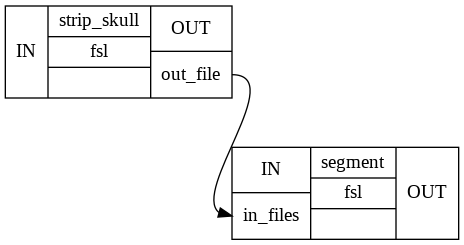

In [ ]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="/output/working_dir/test_workflow/graph_detailed.png")

That looks good. As you can see on the graph above, we will first perform skullstripping and then use its output file as the input file for the segmentation. 

We are now ready to execute the workflow. This can be done by calling the ```run()``` method (note that segmentation takes about 4 minutes to run on Colab as it's a rather computional heavy procedure):

In [ ]:
wf.run()

220902-15:20:34,230 nipype.workflow INFO:
	 Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']


220902-15:20:34,244 nipype.workflow INFO:
	 Running serially.


INFO:nipype.workflow:Running serially.


220902-15:20:34,249 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.strip_skull" in "/output/working_dir/test_workflow/strip_skull".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.strip_skull" in "/output/working_dir/test_workflow/strip_skull".


220902-15:20:34,260 nipype.workflow INFO:
	 [Node] Cached "test_workflow.strip_skull" - collecting precomputed outputs


INFO:nipype.workflow:[Node] Cached "test_workflow.strip_skull" - collecting precomputed outputs


220902-15:20:34,264 nipype.workflow INFO:
	 [Node] "test_workflow.strip_skull" found cached.


INFO:nipype.workflow:[Node] "test_workflow.strip_skull" found cached.


220902-15:20:34,269 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.segment" in "/output/working_dir/test_workflow/segment".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.segment" in "/output/working_dir/test_workflow/segment".


220902-15:20:34,286 nipype.workflow INFO:
	 [Node] Cached "test_workflow.segment" - collecting precomputed outputs


INFO:nipype.workflow:[Node] Cached "test_workflow.segment" - collecting precomputed outputs


220902-15:20:34,290 nipype.workflow INFO:
	 [Node] "test_workflow.segment" found cached.


INFO:nipype.workflow:[Node] "test_workflow.segment" found cached.


Great! A few cells above, we have defined ```/output/working_dir``` as the base directory of our workflow - here, every node has a separate subdirectory where its outputs and additional info are stored. Looking at the working directory of the segmentation node ```/output/working_dir/test-workflow/segment``` you can see that a lot of files have been created. One way to access the node results is to load the results file stored in the directory (ending with ```.pklz```) using Nipype's ```loadpkl``` function:

In [ ]:
from nipype.utils.filemanip import loadpkl
segment_results = loadpkl("/output/working_dir/test_workflow/segment/result_segment.pklz")
print(segment_results.outputs)


bias_field = <undefined>
mixeltype = /output/working_dir/test_workflow/segment/sub-01_T1w_brain_mixeltype.nii
partial_volume_files = ['/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_0.nii', '/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_1.nii', '/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_2.nii']
partial_volume_map = /output/working_dir/test_workflow/segment/sub-01_T1w_brain_pveseg.nii
probability_maps = <undefined>
restored_image = <undefined>
tissue_class_files = <undefined>
tissue_class_map = /output/working_dir/test_workflow/segment/sub-01_T1w_brain_seg.nii



Let's have a look at the three partial volume files that have been created. These files represent the tissue types that have been segmented (i.e., Grey Matter, White Matter and CSF). According to the [FSL documentation](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) "*each voxel contains a value in the range 0-1 that represents the proportion of that class's tissue present in that voxel*".

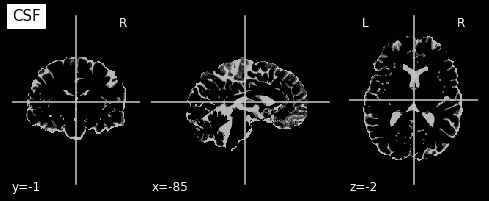

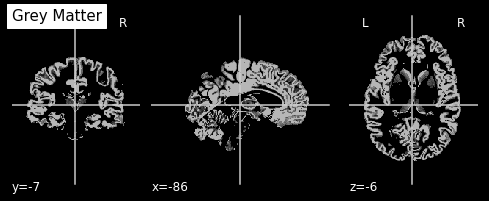

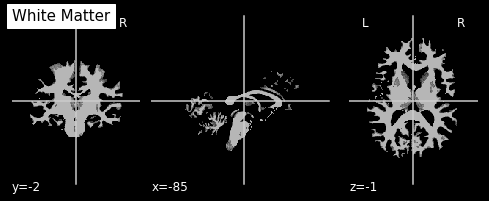

In [ ]:
plot_labels = {0: "CSF", 1: "Grey Matter", 2: "White Matter"}

for i, label in plot_labels.items():
  plotting.plot_anat(f"/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_{i}.nii",
                     title = label)

## Exercise

In this notebook, we illustrated Nipype Nodes and Workflows only on the anatomical image. The goal of the individual assignment will be to preprocess both the functional and anatomical image so that a first level analysis can be performed. This exercise includes the first steps of the preprocessing of the functional image. The exact steps are: 

- Setup a new workflow
- Setup a node for Slicetime correction (using [```fsl.SliceTimer```](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html#slicetimer))
  - Use ```/data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz``` as the input file
  - You will need the Repitition Time (TR): You can find it by inspecting either the header of the functional image (using Nibabel) or the ```task-flanker_bold.json``` file in the data directory
  - Assume interleaved slice acquisition
- Setup a node for motion correction (using [```fsl.MCFLIRT```](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html#mcflirt))
  - Use mean registration
  - Save transformation (motion) parameters
- Connect the nodes
- Run the workflow


In [ ]:
from nipype.interfaces.fsl import SliceTimer, MCFLIRT

# define nodes
slicetimer = Node(SliceTimer(in_file = "/data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz",
                             time_repetition = 2.0,
                             interleaved = True),
                  name="slicetimer")

realigner = Node(MCFLIRT(mean_vol=True,
                         save_plots=True),
                 name="realigner")

# initialize workflow and connect nodes
wf2 = Workflow(name="test2", base_dir="/output/working_dir")
wf2.connect([(slicetimer, realigner, [("slice_time_corrected_file", "in_file")])])

wf2.run()

### Bonus Exercise

Try investigating different brain extraction thresholds. Create an array with from 0.1 to 0.8 in steps of 0.2. Call ```BET``` within a loop to perform brain extraction for every threshold specified in the array. Finally, plot all output images

## Resources

[Nipype Tutorial on Nodes](https://miykael.github.io/nipype_tutorial/notebooks/basic_nodes.html)

[Nipype Tutorial on Workflows](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html)



## References

Kalavathi, P., & Prasath, V. B. (2016). Methods on Skull Stripping of MRI Head Scan Images-a Review. Journal of digital imaging, 29(3), 365–379. https://doi.org/10.1007/s10278-015-9847-8